In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import matplotlib as mpl

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #正常显示负号
pd.set_option('display.max_columns',6)
pd.set_option('display.max_rows',6)


In [2]:
data_raw = pd.read_pickle("sse50_2023-11-10.pkl")
data_raw


,date,tradecode,exerciseprice,close,settlement_price,S0
1,2023-11-10,510050C2312A02400,2.40,0.1198,0.1198,2.49
2,2023-11-10,510050C2312A02450,2.45,0.0832,0.0832,2.49
3,2023-11-10,510050C2312A02500,2.50,0.0552,0.0552,2.49
...,...,...,...,...,...,...
104,2023-11-10,510050P2406A02700,2.70,0.2245,0.2240,2.49
105,2023-11-10,510050C2406A02750,2.75,0.0556,0.0556,2.49
106,2023-11-10,510050P2406A02750,2.75,0.2605,0.2606,2.49


In [3]:
option = data_raw.copy()
option["contract_month"] = option["tradecode"].str[7:11]
option["contract_month"]


1      2312
2      2312
3      2312
       ... 
104    2406
105    2406
106    2406
Name: contract_month, Length: 106, dtype: object

In [4]:
option["CP"] = np.where(option["tradecode"].str[6:7] == "C",0,1) # 0表示看涨期权，1表示看跌期权。
option["实虚值"] = np.where(((option["CP"]==0) & (option["exerciseprice"]>option["S0"]))|((option["CP"]==1) & (option["exerciseprice"]<option["S0"])),"虚值","实值")
option


,date,tradecode,exerciseprice,...,contract_month,CP,实虚值
1,2023-11-10,510050C2312A02400,2.40,...,2312,0,实值
2,2023-11-10,510050C2312A02450,2.45,...,2312,0,实值
3,2023-11-10,510050C2312A02500,2.50,...,2312,0,虚值
...,...,...,...,...,...,...,...
104,2023-11-10,510050P2406A02700,2.70,...,2406,1,实值
105,2023-11-10,510050C2406A02750,2.75,...,2406,0,虚值
106,2023-11-10,510050P2406A02750,2.75,...,2406,1,实值


In [5]:
def get_forth_Weds(contract_month): #获取每个月第四个周三的日期，ETF期权到期日
    first_7D = pd.date_range("20"+contract_month+"01","20"+contract_month+"07")
    list_day = first_7D.weekday  #返回第一个7天的周几，周一为0，周三对应的是2
    first_Wed = list_day.get_indexer([2])  #第一个周三对应的是2，返回第一个周三的索引
    forth_Wed = first_7D[first_Wed] + pd.DateOffset(weeks = 3)
    return forth_Wed.values[0]


In [6]:
option["last_day"] = option["contract_month"].map(get_forth_Weds)
option["maturity"] = (option["last_day"] - option["date"])/pd.to_timedelta(242,"D")
option


,date,tradecode,exerciseprice,...,实虚值,last_day,maturity
1,2023-11-10,510050C2312A02400,2.40,...,实值,2023-12-27,0.194215
2,2023-11-10,510050C2312A02450,2.45,...,实值,2023-12-27,0.194215
3,2023-11-10,510050C2312A02500,2.50,...,虚值,2023-12-27,0.194215
...,...,...,...,...,...,...,...
104,2023-11-10,510050P2406A02700,2.70,...,实值,2024-06-26,0.946281
105,2023-11-10,510050C2406A02750,2.75,...,虚值,2024-06-26,0.946281
106,2023-11-10,510050P2406A02750,2.75,...,实值,2024-06-26,0.946281


In [7]:
r = 0.0203
option["r"] = r


In [8]:
def idx_min(data):
    moneyness = np.abs(data["S0"]-data["exerciseprice"])
    return data.loc[moneyness.idxmin()]
atm_contract = option.groupby(["contract_month","CP"]).apply(idx_min)
atm_contract


C:\Users\Jincheng Gong\AppData\Local\Temp\ipykernel_5060\3779619937.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  atm_contract = option.groupby(["contract_month","CP"]).apply(idx_min)


date          tradecode  exerciseprice  ...  \
contract_month CP                                               ...   
2311           0  2023-11-10  510050C2311M02500            2.5  ...   
               1  2023-11-10  510050P2311M02500            2.5  ...   
2312           0  2023-11-10  510050C2312A02500            2.5  ...   
...                      ...                ...            ...  ...   
2403           1  2023-11-10  510050P2403A02500            2.5  ...   
2406           0  2023-11-10  510050C2406A02500            2.5  ...   
               1  2023-11-10  510050P2406A02500            2.5  ...   

                    last_day  maturity       r  
contract_month CP                               
2311           0  2023-11-22  0.049587  0.0203  
               1  2023-11-22  0.049587  0.0203  
2312           0  2023-12-27  0.194215  0.0203  
...                      ...       ...     ...  
2403           1  2024-03-27  0.570248  0.0203  
2406           0  2024-06-26  0.946281  0.0203  
               1  2024-06-26  0.946281  0.0203  

[8 rows x 12 columns]

In [12]:
idx = pd.IndexSlice
C = atm_contract.loc[idx[:,0],"close"].values 
P = atm_contract.loc[idx[:,1],"close"].values
K = atm_contract.loc[idx[:,0],"exerciseprice"].values 
T = atm_contract.loc[idx[:,0],"maturity"].values
r = atm_contract.loc[idx[:,0],"r"].values
F = np.exp(r*T)*(C-P)+K  #平价公式
F_data =  pd.DataFrame({"contract_month":atm_contract["contract_month"].unique(),"F":F})
F_data


,contract_month,F
0,2311,2.492693
1,2312,2.501305
2,2403,2.523571
3,2406,2.542101


In [13]:
option_2 = pd.merge(option,F_data)
option_2["q"] = option_2["r"] - np.log(option_2["F"]/option_2["S0"])/option_2["maturity"]
option_2


,date,tradecode,exerciseprice,...,r,F,q
0,2023-11-10,510050C2312A02400,2.40,...,0.0203,2.501305,-0.003024
1,2023-11-10,510050C2312A02450,2.45,...,0.0203,2.501305,-0.003024
2,2023-11-10,510050C2312A02500,2.50,...,0.0203,2.501305,-0.003024
...,...,...,...,...,...,...,...
103,2023-11-10,510050P2406A02700,2.70,...,0.0203,2.542101,-0.001584
104,2023-11-10,510050C2406A02750,2.75,...,0.0203,2.542101,-0.001584
105,2023-11-10,510050P2406A02750,2.75,...,0.0203,2.542101,-0.001584


In [14]:
from numpy import exp  #直接导入exp，省的每次都要写np.exp
from scipy.stats import norm #直接导入norm，省的每次都要写stats.norm
def BSM(CP,S,X,sigma,T,r,b):
    d1 = (np.log(S/X) + (b + sigma**2/2)*T) / (sigma* np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * exp((b - r)*T) *norm.cdf(d1) - X * exp(-r*T) * norm.cdf(d2)
    put_price =  X * exp(-r*T) * norm.cdf(-d2) - S * exp((b - r)*T) * norm.cdf(-d1)
    value = call_price + CP*(put_price-call_price)
    return value
def newton_imp_vol(C0,CP,S,X,T,r,b,vol_est = 0.25,n_iter=1000):
    # n_iter表示迭代的次数
    for i in range(n_iter):
        d1 = (np.log(S/X) + (b + vol_est**2/2)*T) / (vol_est* np.sqrt(T))
        vega = S * exp((b-r)*T) * norm.pdf(d1) * T**0.5 # 计算vega
        vol_est = vol_est - (BSM(CP,S,X,vol_est,T,r,b) - C0) / vega  #每次迭代都重新算一下波动率
    return vol_est
option_2["market_imp_vol"] = newton_imp_vol(C0=option_2["close"],CP = option_2["CP"],S = option_2["S0"],X = option_2["exerciseprice"],
                                            T = option_2["maturity"],r=option_2["r"],b=option_2["r"]-option_2["q"],vol_est = 0.25,n_iter=500)


In [16]:
# 逆向校验
model_price = BSM(CP = option_2["CP"],S =option_2["S0"],X = option_2["exerciseprice"],
                  sigma  = option_2["market_imp_vol"] ,T = option_2["maturity"],r=option_2["r"],b=option_2["r"]-option_2["q"] )
error_item = np.round(model_price - option_2["close"],4).sum()
error_item


0.0

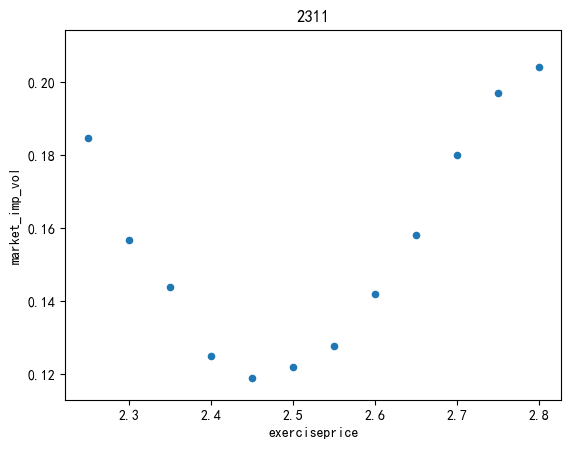

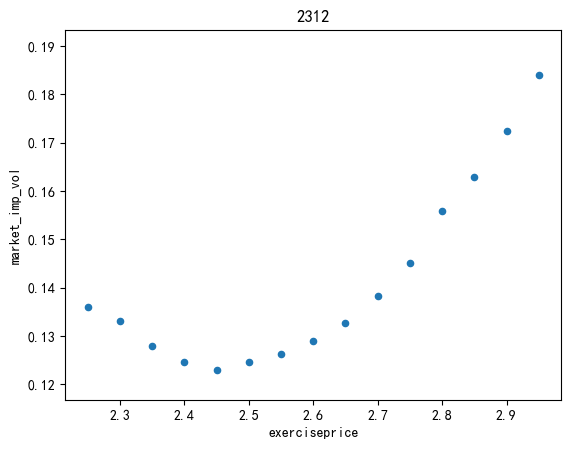

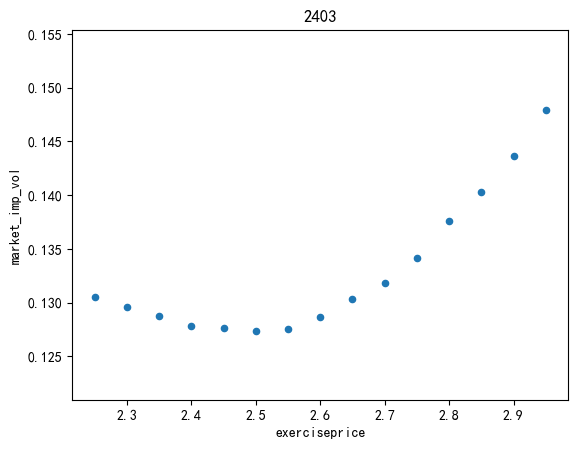

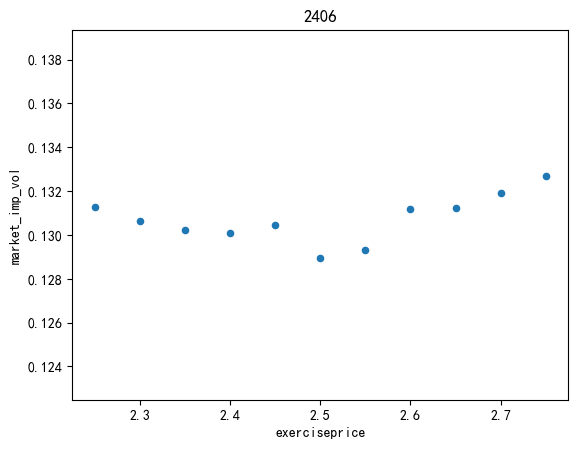

In [17]:
for contract in np.sort(option_2["contract_month"].unique()):
    fit_option = option_2[(option_2["实虚值"]=="虚值")&(option_2["settlement_price"]>0.0001)&(option_2["contract_month"]==contract)]
    fit_option[["exerciseprice","market_imp_vol"]].plot(kind ="scatter",x="exerciseprice",y="market_imp_vol")
    plt.ylim((fit_option["market_imp_vol"].min()*0.95,fit_option["market_imp_vol"].max()*1.05))
    plt.title(contract)


In [20]:
fit_option

,date,tradecode,exerciseprice,...,F,q,market_imp_vol
89,2023-11-10,510050C2406A02500,2.50,...,2.542101,-0.001584,0.128927
90,2023-11-10,510050C2406A02550,2.55,...,2.542101,-0.001584,0.129292
91,2023-11-10,510050C2406A02600,2.60,...,2.542101,-0.001584,0.131178
...,...,...,...,...,...,...,...
97,2023-11-10,510050P2406A02450,2.45,...,2.542101,-0.001584,0.130456
102,2023-11-10,510050C2406A02700,2.70,...,2.542101,-0.001584,0.131906
104,2023-11-10,510050C2406A02750,2.75,...,2.542101,-0.001584,0.132710


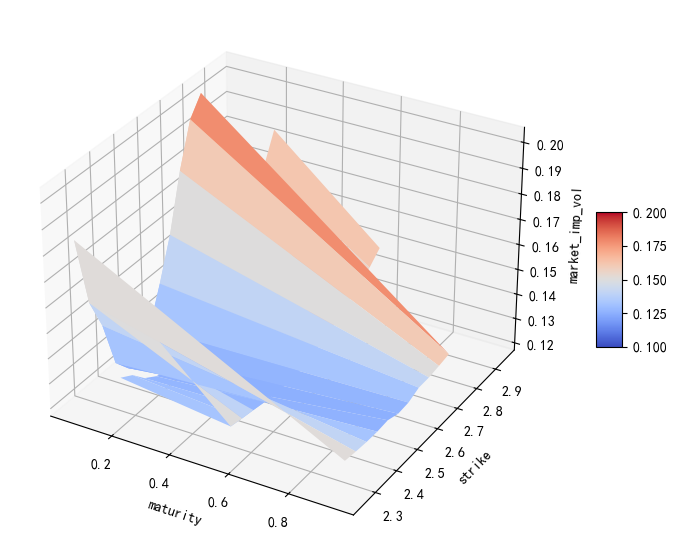

In [18]:
# 后续要plot_surface的使用，通常要借助np.meshgrid生成二维数组，并将波动率数据对齐
def get_ivs_data(data):
    maturities = data["maturity"].unique()
    strikes = np.sort(data["exerciseprice"].unique())
    t, k = np.meshgrid(maturities,strikes) 
    v = np.zeros_like(k)

    # 遍历strike和maturity，获取对应的波动率数据
    for k1 in enumerate(strikes):  #enumerate同时获取列表的元素和索引
        for t1 in enumerate(maturities):
             tem = data.loc[(data["maturity"] == t1[1]) & (data["exerciseprice"] == k1[1])]["market_imp_vol"].values
             if len(tem) == 0: 
                 v[k1[0],t1[0]] = np.nan
             else:
                 v[k1[0],t1[0]] = tem[0]
    return t,k,v
# 根据3维数据生成曲面图像
def plot_ivs(t,k,v):
    fig = plt.figure(figsize=(12, 7))
    ax = plt.axes(projection='3d')
    norm = mpl.colors.Normalize(vmin=0.1, vmax=0.2)
    # 绘图主程序
    surf = ax.plot_surface(t, k, v, rstride=1, cstride=1,
    cmap=plt.cm.coolwarm,norm = norm,linewidth=0.5, antialiased=True)
    # 设置坐标轴
    ax.set_xlabel('maturity')
    ax.set_ylabel('strike')
    ax.set_zlabel('market_imp_vol')
    fig.colorbar(surf, shrink=0.25, aspect=5)
t,k,v = get_ivs_data(option_2[option_2["实虚值"]=="虚值"])
plot_ivs(t,k,v)


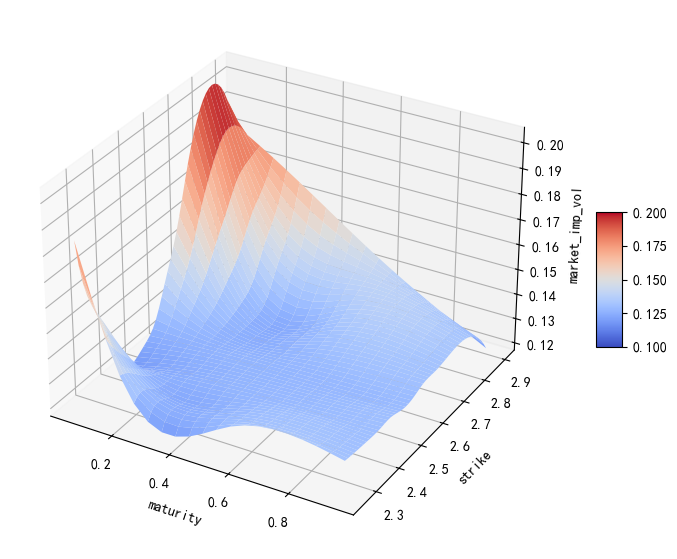

In [19]:
def get_interplote_ivs_data(data):
    data = data.sort_values(["contract_month","exerciseprice"]) #样条插值是需要排序的数据
    t_array = np.linspace(data["maturity"].min(),data["maturity"].max(),20)
    k_array = np.linspace(data["exerciseprice"].min(),data["exerciseprice"].max()-0.05,50)#这里行权价格范围这里可以稍微调整一下，减少外插的影响 
    t, k = np.meshgrid(t_array,k_array) 
    v = np.zeros_like(k)

    #先将几个合约月份的样条插值函数存储进列表
    spline = []
    for m in data["maturity"].unique():
        sample_strike = data.loc[data["maturity"] == m]["exerciseprice"]
        sample_volatility = data.loc[data["maturity"] == m]["market_imp_vol"]
        cs_k = CubicSpline(x =sample_strike,y = sample_volatility,bc_type = "not-a-knot",extrapolate=True)
        spline.append(cs_k)

    # 循环确定每个点的隐含波动率，上一步已经存储了k维度上的样条函数，循环的时候还需要t维度的样条插值，这样可以计算任意点的隐含波动率值
    for t1 in enumerate(t_array):
        for k1 in enumerate(k_array):
            volatility_at_k1 = [float(cs(k1[1])) for cs in spline]
            cs = CubicSpline(x =data["maturity"].unique(),y = volatility_at_k1,bc_type = "natural")
            volatility = float(cs(t1[1]))
            v[k1[0],t1[0]] = volatility
    return t,k,v
t,k,v = get_interplote_ivs_data(option_2[option_2["实虚值"]=="虚值"])
plot_ivs(t,k,v)
